# ML_MariaJoseCamacho - Predicci√≥n de Rotaci√≥n de Empleados (Employee Attrition)
## **Paso 1: Entendiendo el problema**


"""
Este proyecto desarrolla un modelo de Machine Learning para predecir qu√© empleados tienen mayor probabilidad de abandonar una empresa ("Attrition"). Se trata de un problema de clasificaci√≥n binaria, cuyo objetivo es anticipar la rotaci√≥n laboral y facilitar decisiones estrat√©gicas en recursos humanos.

Por √∫ltimo agruparemos los diferentes perfiles de los trabajadores mediante modelos no supervisados.
"""


## **Paso 2: Carga de librer√≠as**


In [60]:
import pandas as pd
import numpy as np
import math                                                         
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.stats import chi2_contingency
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer, recall_score, ConfusionMatrixDisplay
import joblib

## **Paso 3: Carga de datos y viwsualizaci√≥n inicial**
(Selecci√≥n de variables, tratamiento de nulos, escalado si es necesario)


In [2]:
# Cargar los datos de nuestro dataset
file_path = r"C:\Users\marij\Documents\dataset ML\WA_Fn-UseC_-HR-Employee-Attrition.csv"
df = pd.read_csv(file_path)
df.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

In [3]:
# Esta es la dimensi√≥n del dataset total
df.shape

(1470, 35)

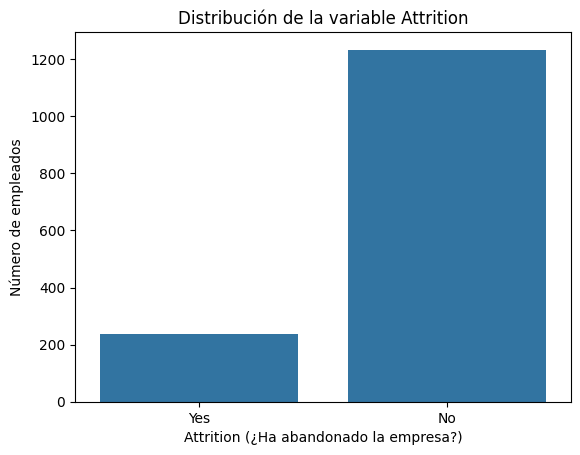

In [4]:
# Visualizamos la variable objetivo
sns.countplot(x='Attrition', data=df)
plt.title('Distribuci√≥n de la variable Attrition')
plt.xlabel('Attrition (¬øHa abandonado la empresa?)')
plt.ylabel('N√∫mero de empleados')
plt.show()

In [5]:
# Conteo de la variable objetivo
print(df['Attrition'].value_counts())

# Porcentaje de cada valor de la variable
print(df['Attrition'].value_counts(normalize=True) * 100)

Attrition
No     1233
Yes     237
Name: count, dtype: int64
Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64


El dataset est√° desbalanceado (~16% abandonos), por lo que priorizaremos m√©tricas como recall.

### üìÑ Descripci√≥n de las variables del dataset

| Columna                     | Descripci√≥n                                                                 |
|-----------------------------|-----------------------------------------------------------------------------|
| **Age**                     | Edad del empleado.                                                          |
| **Attrition**               | Si el empleado ha abandonado la empresa (`Yes`) o no (`No`).               |
| **BusinessTravel**          | Frecuencia con la que el empleado viaja por trabajo.                        |
| **Department**              | Departamento en el que trabaja el empleado (Ventas, I+D, RRHH).             |
| **DistanceFromHome**        | Distancia (en millas) desde su casa al trabajo.                             |
| **Education**               | Nivel educativo (1=Menor, 5=Mayor).                                         |
| **EducationField**          | √Årea de formaci√≥n (Ciencias, Marketing, Medicina, etc.).                    |
| **EnvironmentSatisfaction** | Grado de satisfacci√≥n con el entorno laboral (1 a 4).                      |
| **Gender**                  | G√©nero del empleado.                                                        |
| **JobRole**                 | Cargo o puesto de trabajo espec√≠fico.                                       |
| **JobSatisfaction**         | Grado de satisfacci√≥n con su trabajo (1 a 4).                               |
| **MaritalStatus**           | Estado civil (Soltero, Casado, Divorciado).                                |
| **MonthlyIncome**           | Ingreso mensual.                                                            |
| **NumCompaniesWorked**      | N√∫mero de empresas anteriores en las que ha trabajado.                      |
| **OverTime**                | Si realiza horas extra (`Yes` o `No`).                                      |
| **PercentSalaryHike**       | Porcentaje del √∫ltimo aumento salarial.                                    |
| **StockOptionLevel**        | Nivel de participaci√≥n accionarial.                                        |
| **TotalWorkingYears**       | A√±os totales de experiencia laboral.                                        |
| **TrainingTimesLastYear**   | N√∫mero de formaciones completadas el √∫ltimo a√±o.                           |
| **WorkLifeBalance**         | Equilibrio entre vida personal y trabajo (1=Malo, 4=Excelente).             |
| **YearsAtCompany**          | A√±os que lleva en la empresa.                                              |
| **YearsInCurrentRole**      | A√±os en su puesto actual.                                                  |
| **YearsSinceLastPromotion** | A√±os desde la √∫ltima promoci√≥n.                                            |
| **YearsWithCurrManager**    | A√±os trabajando con el actual supervisor.                                   |


## **Paso 4: An√°lisis exploratorio (Mini EDA)**

En este paso exploramos la estructura y caracter√≠sticas principales del dataset para entender mejor la variable objetivo y las posibles relaciones con otras variables.



In [6]:
# Valores nulos
print(df.isnull().sum().sort_values(ascending=False).head())

Age               0
Attrition         0
BusinessTravel    0
DailyRate         0
Department        0
dtype: int64


In [7]:
# Estad√≠sticas generales
df.describe()

Age    DailyRate  DistanceFromHome    Education  EmployeeCount  \
count  1470.000000  1470.000000       1470.000000  1470.000000         1470.0   
mean     36.923810   802.485714          9.192517     2.912925            1.0   
std       9.135373   403.509100          8.106864     1.024165            0.0   
min      18.000000   102.000000          1.000000     1.000000            1.0   
25%      30.000000   465.000000          2.000000     2.000000            1.0   
50%      36.000000   802.000000          7.000000     3.000000            1.0   
75%      43.000000  1157.000000         14.000000     4.000000            1.0   
max      60.000000  1499.000000         29.000000     5.000000            1.0   

       EmployeeNumber  EnvironmentSatisfaction   HourlyRate  JobInvolvement  \
count     1470.000000              1470.000000  1470.000000     1470.000000   
mean      1024.865306                 2.721769    65.891156        2.729932   
std        602.024335                 1.093082    20.329428        0.711561   
min          1.000000                 1.000000    30.000000        1.000000   
25%        491.250000                 2.000000    48.000000        2.000000   
50%       1020.500000                 3.000000    66.000000        3.000000   
75%       1555.750000                 4.000000    83.750000        3.000000   
max       2068.000000                 4.000000   100.000000        4.000000   

          JobLevel  ...  RelationshipSatisfaction  StandardHours  \
count  1470.000000  ...               1470.000000         1470.0   
mean      2.063946  ...                  2.712245           80.0   
std       1.106940  ...                  1.081209            0.0   
min       1.000000  ...                  1.000000           80.0   
25%       1.000000  ...                  2.000000           80.0   
50%       2.000000  ...                  3.000000           80.0   
75%       3.000000  ...                  4.000000           80.0   
max       5.000000  ...                  4.000000           80.0   

       StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  \
count       1470.000000        1470.000000            1470.000000   
mean           0.793878          11.279592               2.799320   
std            0.852077           7.780782               1.289271   
min            0.000000           0.000000               0.000000   
25%            0.000000           6.000000               2.000000   
50%            1.000000          10.000000               3.000000   
75%            1.000000          15.000000               3.000000   
max            3.000000          40.000000               6.000000   

       WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  \
count      1470.000000     1470.000000         1470.000000   
mean          2.761224        7.008163            4.229252   
std           0.706476        6.126525            3.623137   
min           1.000000        0.000000            0.000000   
25%           2.000000        3.000000            2.000000   
50%           3.000000        5.000000            3.000000   
75%           3.000000        9.000000            7.000000   
max           4.000000       40.000000           18.000000   

       YearsSinceLastPromotion  YearsWithCurrManager  
count              1470.000000           1470.000000  
mean                  2.187755              4.123129  
std                   3.222430              3.568136  
min                   0.000000              0.000000  
25%                   0.000000              2.000000  
50%                   1.000000              3.000000  
75%                   3.000000              7.000000  
max                  15.000000             17.000000  

[8 rows x 26 columns]

In [8]:
# Correlaci√≥n con variable objetivo binarizada
df["Attrition_bin"] = df["Attrition"].map({"Yes": 1, "No": 0})
correlaciones = df.corr(numeric_only=True)["Attrition_bin"].sort_values(ascending=False)
print(correlaciones)

Attrition_bin               1.000000
DistanceFromHome            0.077924
NumCompaniesWorked          0.043494
MonthlyRate                 0.015170
PerformanceRating           0.002889
HourlyRate                 -0.006846
EmployeeNumber             -0.010577
PercentSalaryHike          -0.013478
Education                  -0.031373
YearsSinceLastPromotion    -0.033019
RelationshipSatisfaction   -0.045872
DailyRate                  -0.056652
TrainingTimesLastYear      -0.059478
WorkLifeBalance            -0.063939
EnvironmentSatisfaction    -0.103369
JobSatisfaction            -0.103481
JobInvolvement             -0.130016
YearsAtCompany             -0.134392
StockOptionLevel           -0.137145
YearsWithCurrManager       -0.156199
Age                        -0.159205
MonthlyIncome              -0.159840
YearsInCurrentRole         -0.160545
JobLevel                   -0.169105
TotalWorkingYears          -0.171063
EmployeeCount                    NaN
StandardHours                    NaN
N

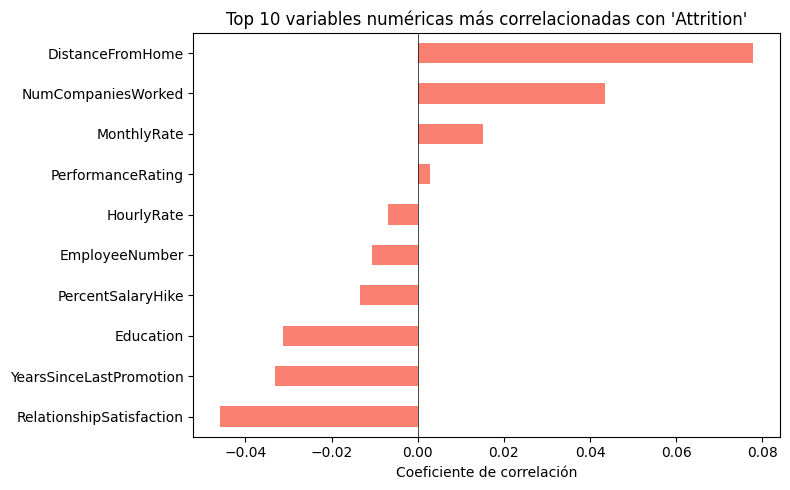

In [9]:
# Visualizamos las 10 variables num√©ricas m√°s correlacionadas con la rotaci√≥n
plt.figure(figsize=(8, 5))
correlaciones.drop("Attrition_bin").head(10).plot(kind='barh', color='salmon')
plt.title("Top 10 variables num√©ricas m√°s correlacionadas con 'Attrition'")
plt.xlabel("Coeficiente de correlaci√≥n")
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Tras analizar las correlaciones num√©ricas con la variable objetivo (`Attrition_bin`), observamos que algunas variables presentan coeficientes muy cercanos a cero, lo que indica que tienen poca o ninguna relaci√≥n lineal con la rotaci√≥n de empleados.

Variables como `EmployeeNumber`, `PerformanceRating`, `HourlyRate` o `PercentSalaryHike` muestran una correlaci√≥n muy baja o negativa con `Attrition_bin`. Por ello, en el siguiente paso procederemos a **descartar estas variables consideradas poco relevantes** para mejorar la eficiencia y la interpretabilidad del modelo.

Esta eliminaci√≥n se realizar√° antes del entrenamiento, asegurando que el modelo solo trabaje con variables con potencial predictivo.



In [10]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Attrition_bin'],
      dtype='object')

In [11]:
# Variables num√©ricas que eliminaremos por baja correlaci√≥n o poca variabilidad
cols_a_eliminar = [
    'EmployeeCount',       # constante (1 para todos)
    'StandardHours',       # constante (80 para todos)
    'EmployeeNumber',      # ID √∫nico, no aporta info √∫til
    'Over18'               # si existe, generalmente constante
]

# Algunas variables con correlaci√≥n casi nula o negativa pueden eliminarse tambi√©n:
cols_baja_corr = [
    'PerformanceRating', 
    'HourlyRate', 
    'PercentSalaryHike', 
    'MonthlyRate', 
    'DailyRate', 
    'TrainingTimesLastYear'
]

cols_a_eliminar += cols_baja_corr

# Eliminamos esas columnas del dataframe para el an√°lisis/modelado posterior
dfnew = df.drop(columns=cols_a_eliminar)

print(f"Columnas eliminadas: {cols_a_eliminar}")
dfnew.shape

Columnas eliminadas: ['EmployeeCount', 'StandardHours', 'EmployeeNumber', 'Over18', 'PerformanceRating', 'HourlyRate', 'PercentSalaryHike', 'MonthlyRate', 'DailyRate', 'TrainingTimesLastYear']


(1470, 26)

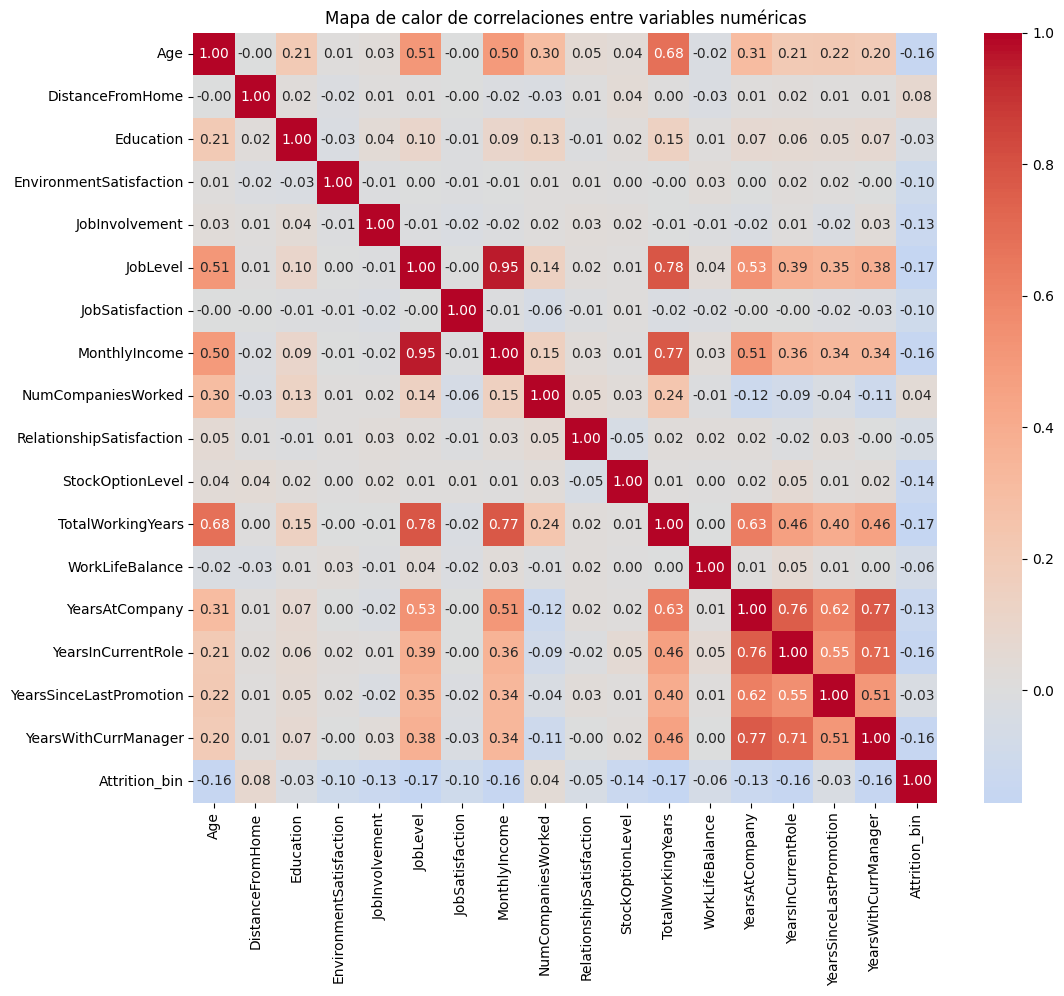

In [12]:
plt.figure(figsize=(12,10))
sns.heatmap(dfnew.select_dtypes(include=['int64', 'float64']).corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Mapa de calor de correlaciones entre variables num√©ricas")
plt.show()

### Interpretaci√≥n del mapa de calor

- Las variables m√°s asociadas con la rotaci√≥n (`Attrition_bin`) son:
  - **JobLevel**, **MonthlyIncome**, **TotalWorkingYears**, **YearsAtCompany**, **JobInvolvement**, todas con coeficientes negativos, lo que indica que a mayor antig√ºedad, implicaci√≥n o salario, menor probabilidad de abandono.
  
- Se observa **colinealidad** entre algunas variables:
  - `MonthlyIncome`, `JobLevel` y `TotalWorkingYears` est√°n altamente correlacionadas (coeficientes > 0.75).
  - `YearsWithCurrManager` y `YearsInCurrentRole` tambi√©n.
  
Estas relaciones deben considerarse al seleccionar variables o aplicar t√©cnicas de reducci√≥n de dimensionalidad.


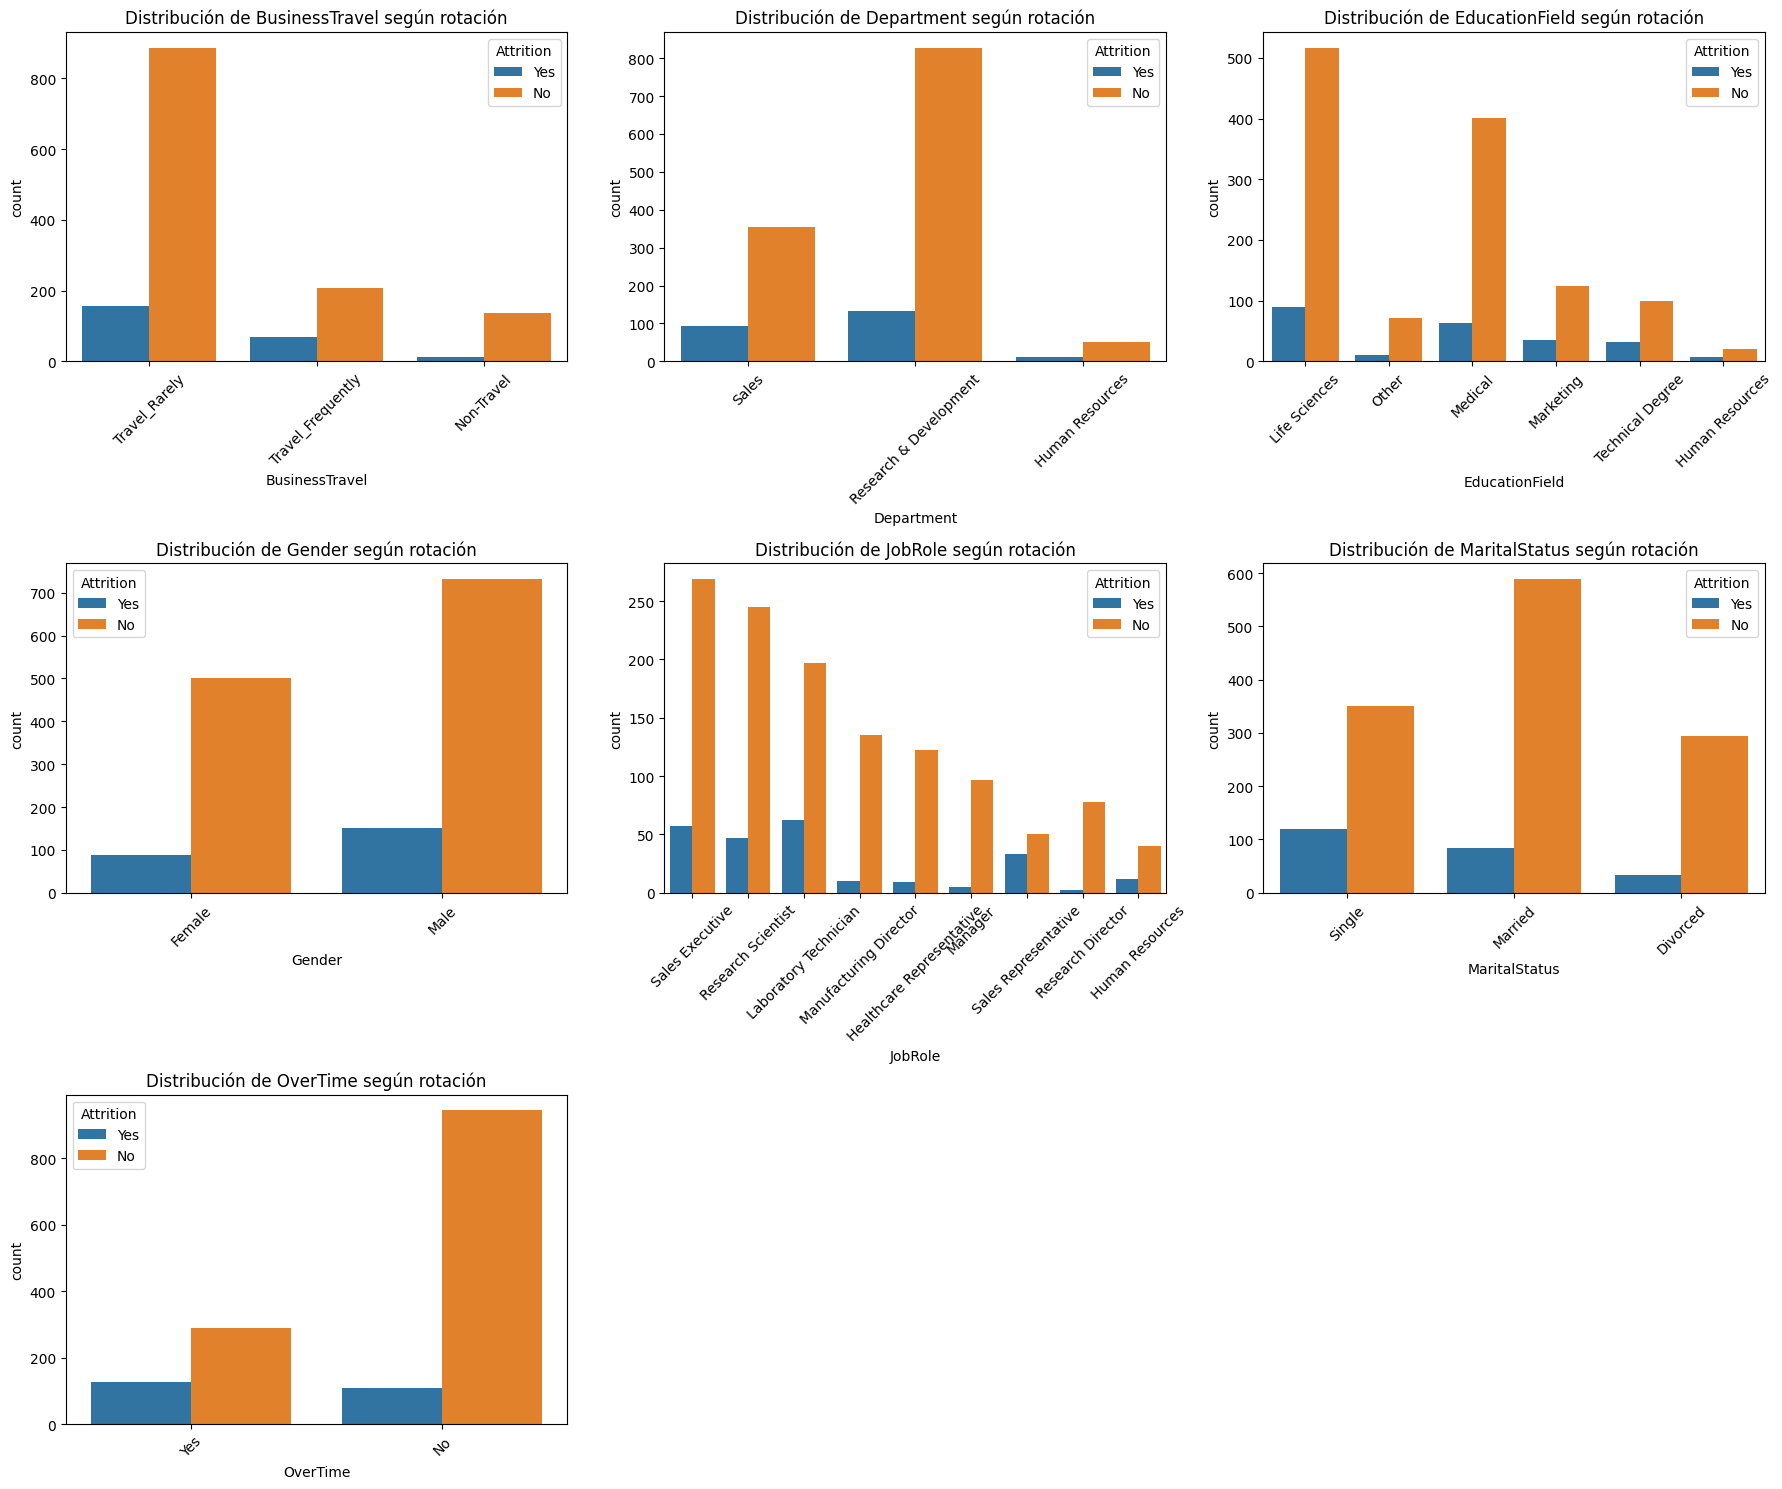

In [13]:
# Columnas categ√≥ricas excluyendo la variable objetivo
categorical_cols = dfnew.select_dtypes(include=['object']).columns.drop('Attrition')

# Definir n√∫mero de columnas (por est√©tica)
n_cols = 3
n_plots = len(categorical_cols)
n_rows = (n_plots + n_cols - 1) // n_cols  # redondeo hacia arriba sin usar math.ceil

# Crear figura
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()

# Visualizar
for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, hue='Attrition', data=dfnew, ax=axes[i])
    axes[i].set_title(f'Distribuci√≥n de {col} seg√∫n rotaci√≥n')
    axes[i].tick_params(axis='x', rotation=45)

# Eliminar subplots vac√≠os
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- Se observan diferencias claras en la distribuci√≥n de la variable `Attrition` seg√∫n varias variables categ√≥ricas.
- Empleados que hacen horas extra (`OverTime = Yes`), que viajan con frecuencia (`BusinessTravel = Travel_Frequently`) o que est√°n solteros (`MaritalStatus = Single`) presentan una mayor proporci√≥n de abandono.
- Algunos roles (`JobRole`) y departamentos tambi√©n muestran tendencias espec√≠ficas en relaci√≥n con la rotaci√≥n.
- Estos patrones visuales sugieren que ciertas categor√≠as est√°n asociadas con un mayor riesgo de abandono, lo que justifica que la incluyamos para el modelado posterior.


In [ ]:
# Test Chi2 para las variables categoricas
for col in categorical_cols:
    tabla = pd.crosstab(dfnew[col], dfnew['Attrition'])
    chi2, p, dof, expected = chi2_contingency(tabla)
    print(f"‚Ü™ {col}: p-valor = {p:.4f}")
    if p < 0.05:
        print("   ‚úî Asociaci√≥n estad√≠sticamente significativa con Attrition")
    else:
        print("   ‚úñ No hay asociaci√≥n significativa con Attrition")
    print("-" * 60)

‚Ü™ BusinessTravel: p-valor = 0.0000
   ‚úî Asociaci√≥n estad√≠sticamente significativa con Attrition
------------------------------------------------------------
‚Ü™ Department: p-valor = 0.0045
   ‚úî Asociaci√≥n estad√≠sticamente significativa con Attrition
------------------------------------------------------------
‚Ü™ EducationField: p-valor = 0.0068
   ‚úî Asociaci√≥n estad√≠sticamente significativa con Attrition
------------------------------------------------------------
‚Ü™ Gender: p-valor = 0.2906
   ‚úñ No hay asociaci√≥n significativa con Attrition
------------------------------------------------------------
‚Ü™ JobRole: p-valor = 0.0000
   ‚úî Asociaci√≥n estad√≠sticamente significativa con Attrition
------------------------------------------------------------
‚Ü™ MaritalStatus: p-valor = 0.0000
   ‚úî Asociaci√≥n estad√≠sticamente significativa con Attrition
------------------------------------------------------------
‚Ü™ OverTime: p-valor = 0.0000
   ‚úî Asociaci√≥n est

In [15]:
# Eliminamos la variable 'Gender' por no aportar informaci√≥n relevante al target
dfnew = dfnew.drop(columns='Gender')

# Confirmamos
print("Gender eliminado. Columnas actuales:")
dfnew.columns.tolist()

Gender eliminado. Columnas actuales:


['Age',
 'Attrition',
 'BusinessTravel',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EnvironmentSatisfaction',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'OverTime',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'Attrition_bin']

### Conclusiones del test Chi-cuadrado

El test Chi-cuadrado confirma que **la mayor√≠a de las variables categ√≥ricas analizadas presentan una asociaci√≥n estad√≠sticamente significativa con la rotaci√≥n de empleados (`Attrition`)**:

- ‚úî `BusinessTravel`, `Department`, `EducationField`, `JobRole`, `MaritalStatus` y `OverTime` tienen un **p-valor < 0.05**, lo que indica que las diferencias observadas en sus categor√≠as respecto a la rotaci√≥n **no son aleatorias**.
- ‚úñ La variable `Gender`, sin embargo, **no muestra una asociaci√≥n significativa**, lo que sugiere que **el g√©nero no influye directamente en la decisi√≥n de abandonar la empresa** en este dataset.

Estos resultados respaldan la elecci√≥n de las variables categ√≥ricas m√°s relevantes para incluir en el preprocesamiento y posterior modelado.


In [ ]:
#  Definici√≥n de columnas categ√≥ricas y num√©ricas

target = 'Attrition'

cat_features = []
num_features = []

for col in dfnew.columns:
    if col == target:
        continue
    if dfnew[col].dtype == 'object' or dfnew[col].dtype.name == 'category':
        cat_features.append(col)
    elif pd.api.types.is_numeric_dtype(dfnew[col]):
        num_features.append(col)

In [ ]:
# Variables num√©ricas que representan categor√≠as
categorical_numeric = [
    'Education',
    'EnvironmentSatisfaction',
    'JobInvolvement',
    'JobLevel',
    'JobSatisfaction',
    'RelationshipSatisfaction',
    'StockOptionLevel',
    'WorkLifeBalance'
]

# Convertimos esas columnas a tipo 'category'
dfnew[categorical_numeric] = dfnew[categorical_numeric].astype('category')

# Creamos las listas finales de variables
cat_features = dfnew.select_dtypes(include=['object', 'category']).columns.drop(['Attrition'])
num_features = dfnew.select_dtypes(include=['int64', 'float64']).columns.drop(['Attrition_bin'])


‚úÖ Variables categ√≥ricas: ['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
‚úÖ Variables num√©ricas: ['Age', 'DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [38]:
# Funci√≥n para visualizar variables num√©ricas por clase del target

def plot_numeric_distributions(df, num_features, target, cols=3, kde=True):
    """
    Visualiza las distribuciones de variables num√©ricas segmentadas por clases del target.
    """
    rows = math.ceil(len(num_features) / cols)
    plt.figure(figsize=(cols * 5, rows * 4))

    for i, col in enumerate(num_features):
        if df[col].nunique() <= 1:
            continue  # Omitir columnas constantes

        plt.subplot(rows, cols, i + 1)
        sns.histplot(
            data=df,
            x=col,
            hue=target,
            kde=kde,
            stat='density',
            common_norm=False,
            palette='Set2',
            alpha=0.6
        )
        plt.title(f'{col} vs {target}')
        plt.xlabel(col)
        plt.ylabel('Densidad')

    plt.tight_layout()
    plt.show()


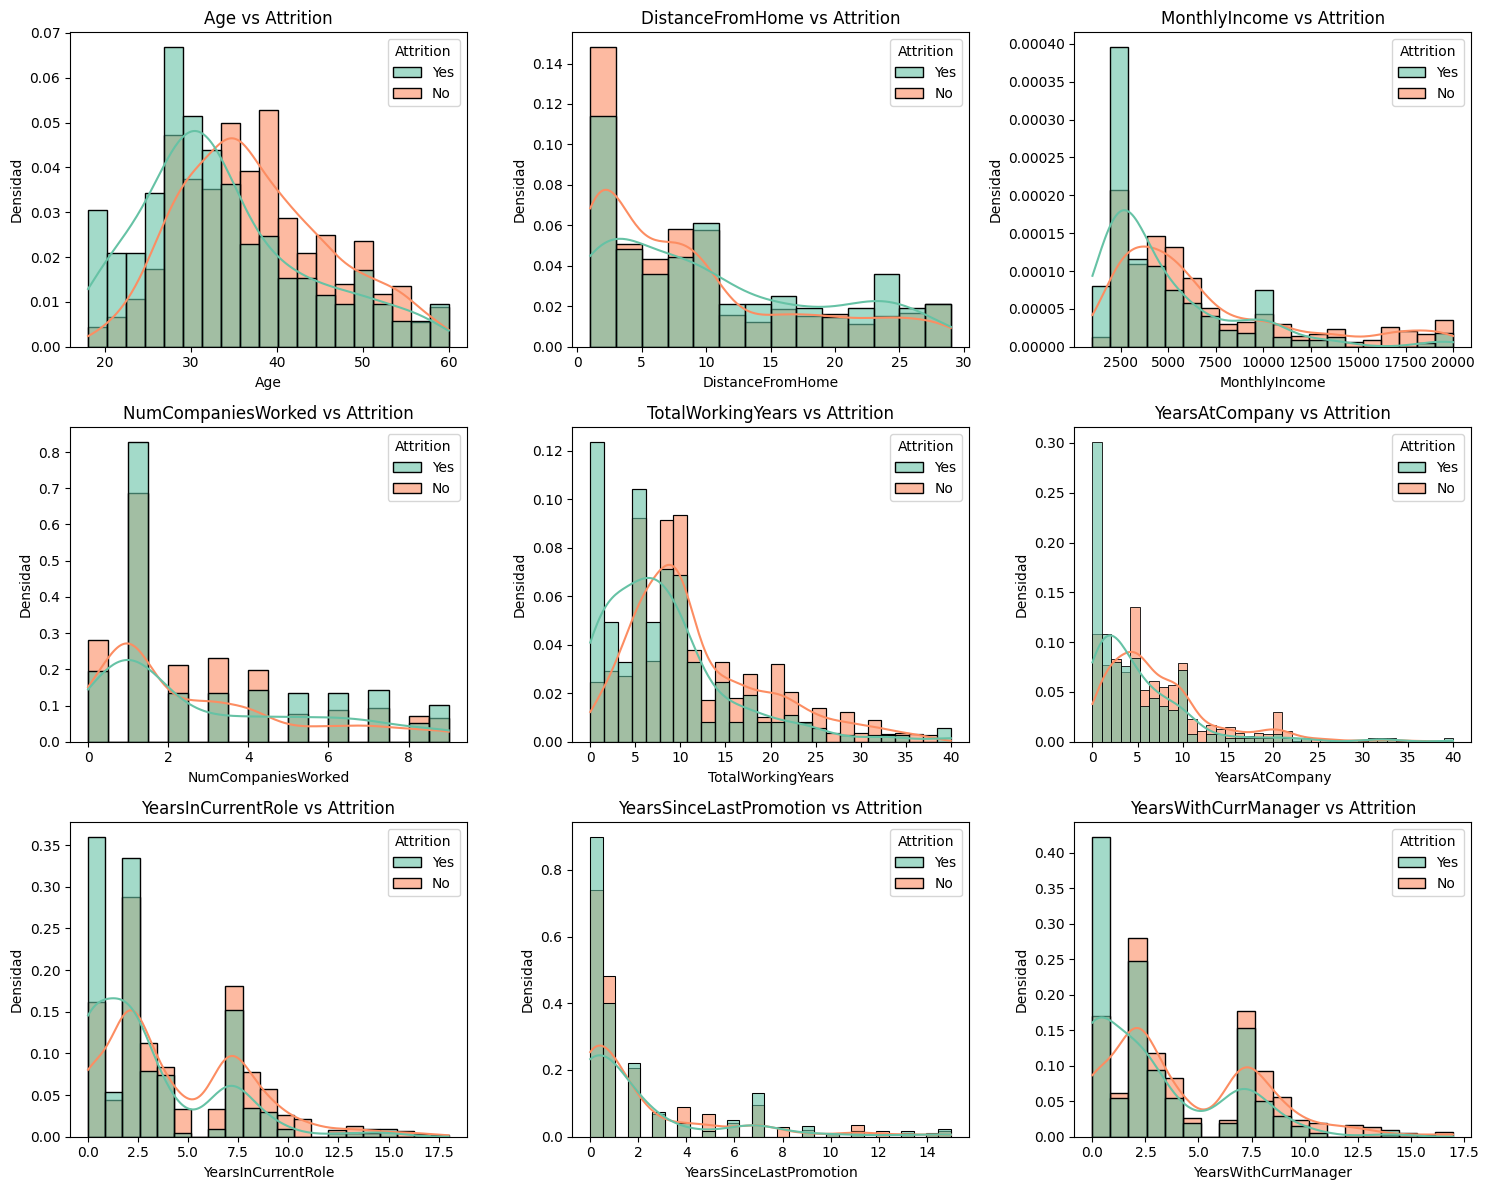

In [39]:
# Visualizaci√≥n final

plot_numeric_distributions(dfnew, num_features=num_features, target=target)

### Conclusi√≥n del an√°lisis exploratorio de variables num√©ricas

A trav√©s de las visualizaciones por clase de `Attrition`, se observan ciertos patrones:

- **Edad (Age)**: Los empleados que abandonan tienden a concentrarse en rangos m√°s j√≥venes (20-35 a√±os), mientras que los que permanecen est√°n m√°s repartidos.
- **MonthlyIncome** y **TotalWorkingYears** muestran distribuciones a la derecha, con empleados que abandonan m√°s concentrados en los niveles bajos de ingresos y experiencia.
- **YearsAtCompany**, **YearsInCurrentRole**, **YearsSinceLastPromotion** y **YearsWithCurrManager** tambi√©n reflejan que los empleados con menor antig√ºedad o sin promociones recientes tienen mayor propensi√≥n a rotar.
- **DistanceFromHome** y **NumCompaniesWorked** presentan diferencias leves, pero indican que ciertos extremos podr√≠an relacionarse con la rotaci√≥n.

Este an√°lisis sugiere que factores como la **edad, experiencia laboral, oportunidades de promoci√≥n y estabilidad en la empresa** est√°n asociados con la probabilidad de rotaci√≥n, lo cual justifica su inclusi√≥n en el modelo predictivo.


## **Paso 5: Preprocesamiento de datos y divisi√≥n del conjunto**

En esta etapa realizamos dos tareas clave:

1. **Preprocesamiento**:
   - Escalamos las variables num√©ricas.
   - Codificamos las variables categ√≥ricas usando One-Hot Encoding (eliminando la primera categor√≠a para evitar multicolinealidad).
   - Usamos `ColumnTransformer` para aplicar estas transformaciones de forma conjunta.

2. **Divisi√≥n de datos**:
   - Separamos el conjunto de datos en entrenamiento y test (80%-20%) para evaluar el rendimiento del modelo con datos no vistos.


In [47]:
# Variables predictoras y target
X = dfnew.drop(columns=['Attrition', 'Attrition_bin'])
y = dfnew['Attrition']

# Divisi√≥n en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocesador: escalado de num√©ricas + one-hot de categ√≥ricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_features)])

# Confirmaci√≥n de las columnas seleccionadas
print("Variables num√©ricas que se escalar√°n:",num_features )

print("Variables categ√≥ricas que se codificar√°n:", cat_features)

print("Tama√±o conjunto entrenamiento:", X_train.shape)
print("Tama√±o conjunto test:", X_test.shape)


Variables num√©ricas que se escalar√°n: Index(['Age', 'DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked',
       'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')
Variables categ√≥ricas que se codificar√°n: Index(['BusinessTravel', 'Department', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'OverTime',
       'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance'],
      dtype='object')
Tama√±o conjunto entrenamiento: (1176, 23)
Tama√±o conjunto test: (294, 23)


En este paso hemos dejado preparados los datos para el modelado:

- Se ha dividido el conjunto en entrenamiento y test manteniendo la proporci√≥n.
- Se ha definido un `ColumnTransformer` que escala las variables num√©ricas y aplica codificaci√≥n One-Hot a las categ√≥ricas.


## **Paso 6: Entrenamiento y comparaci√≥n de modelos base**

El objetivo de este paso es entrenar y comparar varios modelos de clasificaci√≥n utilizando sus **hiperpar√°metros por defecto**, para seleccionar como baseline aquel que muestre mejor rendimiento en la detecci√≥n de empleados que abandonan la empresa (`Attrition = Yes`).

Nos centraremos especialmente en la **m√©trica de `recall`**, ya que nuestro objetivo principal es **detectar con la mayor precisi√≥n posible los casos positivosde los empleados que se van**.



In [54]:
# Scorer personalizado para la clase 'Yes'
recall_yes = make_scorer(recall_score, pos_label='Yes')

# Modelos
modelos = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    }

# Comparaci√≥n
resultados = {}

for nombre, modelo in modelos.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', modelo)
    ])
    
    # Para XGBoost usamos la variable binaria
    if nombre == 'XGBoost':
        y_train_temp = y_train.map({'No': 0, 'Yes': 1})
        recall_binario = make_scorer(recall_score, pos_label=1)
        scores = cross_val_score(pipe, X_train, y_train_temp, cv=5, scoring=recall_binario)
    else:
        scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring=recall_yes)

    resultados[nombre] = {
        'Recall (YES) medio': np.mean(scores),
        'Recall (YES) std': np.std(scores)
    }

# Mostrar resultados
df_resultados = pd.DataFrame(resultados).T.sort_values(by='Recall (YES) medio', ascending=False)
display(df_resultados)

Recall (YES) medio  Recall (YES) std
Logistic Regression            0.447368          0.086483
XGBoost                        0.378947          0.039386
Decision Tree                  0.352632          0.045883
Gradient Boosting              0.352632          0.080854
Random Forest                  0.184211          0.037216
KNN                            0.178947          0.065314

Tras evaluar varios modelos de clasificaci√≥n mediante validaci√≥n cruzada y utilizando el recall sobre la clase "Yes" como m√©trica principal, observamos que **Logistic Regression** se posiciona como el modelo m√°s fiable para detectar empleados que abandonan la empresa.

Con un recall medio de **0.447**, este modelo logra detectar aproximadamente un **45% de los casos reales de abandono**, lo que lo convierte en una opci√≥n s√≥lida como **modelo baseline**. Adem√°s, presenta una desviaci√≥n est√°ndar relativamente baja, lo que indica estabilidad en las distintas particiones del conjunto de entrenamiento.

A partir de este punto, evaluaremos su rendimiento en el conjunto de test y lo consideraremos para una futura optimizaci√≥n.


## Paso 7: Entrenamiento y Evaluaci√≥n del Modelo Baseline

En este paso entrenamos nuestro modelo baseline, seleccionado previamente tras comparar varios algoritmos.  
El modelo elegido es **Logistic Regression**, ya que obtuvo el mejor recall medio sobre la clase `"Yes"` (rotaci√≥n laboral) en validaci√≥n cruzada.  
Nuestro objetivo es evaluar su rendimiento inicial sobre el conjunto de test y establecer una referencia clara para futuras mejoras.

A continuaci√≥n, entrenamos el modelo, realizamos las predicciones y analizamos las m√©tricas de evaluaci√≥n, incluyendo la matriz de confusi√≥n.


 Classification Report - Baseline (Logistic Regression):

              precision    recall  f1-score   support

          No       0.94      0.78      0.85       247
         Yes       0.39      0.72      0.50        47

    accuracy                           0.77       294
   macro avg       0.66      0.75      0.68       294
weighted avg       0.85      0.77      0.80       294



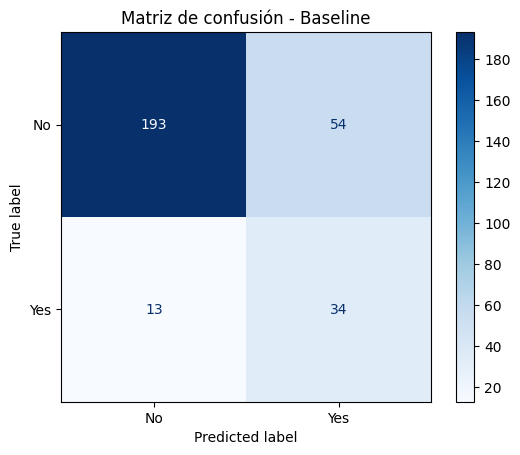

In [58]:
# Creamos un pipeline con el preprocesador y el modelo baseline
baseline_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Entrenamiento del modelo baseline
baseline_model.fit(X_train, y_train)

# Predicciones sobre el conjunto de test
y_pred = baseline_model.predict(X_test)

# Reporte de clasificaci√≥n
print(" Classification Report - Baseline (Logistic Regression):\n")
print(classification_report(y_test, y_pred))

# Matriz de confusi√≥n
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Matriz de confusi√≥n - Baseline")
plt.show()

He utilizado `Logistic Regression` con `class_weight='balanced'` como modelo baseline, ya que ofrece un buen equilibrio entre simplicidad, interpretabilidad y rendimiento inicial.

En el conjunto de test, el modelo ha alcanzado los siguientes resultados:

- **Recall para la clase *Yes* (rotaci√≥n): 0.72**, lo que indica que detecta correctamente al 72% de los empleados que efectivamente abandonan la empresa.
- **Precision para la clase *Yes*: 0.39**, lo que implica que tambi√©n comete falsos positivos. Sin embargo, considero este margen asumible si el objetivo es minimizar la fuga real de trabajadores.
- **Recall macro promedio: 0.75**, lo que sugiere un buen equilibrio entre ambas clases.

Dado que el objetivo principal del proyecto es **priorizar la detecci√≥n fiable de los empleados que podr√≠an marcharse**, este baseline ya representa una base s√≥lida para aplicar posteriormente t√©cnicas de optimizaci√≥n y mejorar su rendimiento.

## Paso 8: Optimizaci√≥n del Modelo

El objetivo de este paso es **mejorar el rendimiento del modelo baseline** aplicando una b√∫squeda de los mejores hiperpar√°metros mediante **validaci√≥n cruzada con `GridSearchCV`**.

Dado que el modelo baseline ya ofrece un rendimiento aceptable, especialmente en el recall de la clase *Yes*, se pretende **afinar el comportamiento del modelo para aumentar su capacidad predictiva sin perder interpretabilidad**.

### Vamos a ...

- Utilizar el algoritmo `LogisticRegression` como base.
- Aplicar validaci√≥n cruzada con `GridSearchCV` para explorar distintas combinaciones de hiperpar√°metros.
- Establecer como **m√©trica de evaluaci√≥n el `recall`**, ya que queremos **detectar la mayor proporci√≥n posible de empleados que podr√≠an abandonar la empresa**.
- Evaluar si el modelo optimizado mejora significativamente respecto al baseline.


Fitting 5 folds for each of 16 candidates, totalling 80 fits
 Mejores hiperpar√°metros encontrados:
{'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

 Classification Report - Modelo Optimizado (Logistic Regression):

              precision    recall  f1-score   support

          No       0.89      0.43      0.58       247
         Yes       0.20      0.72      0.31        47

    accuracy                           0.48       294
   macro avg       0.54      0.58      0.45       294
weighted avg       0.78      0.48      0.54       294



c:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


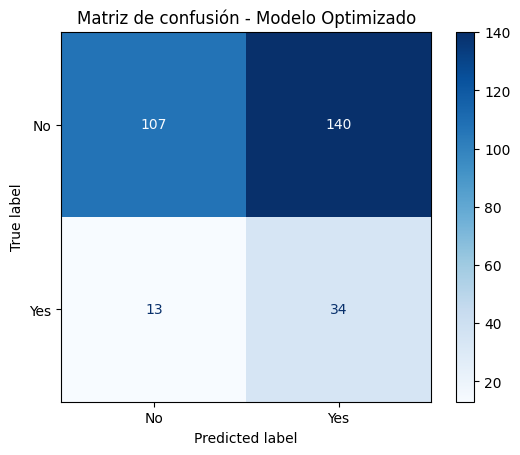

In [65]:
# Definimos el grid de hiperpar√°metros
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__class_weight': ['balanced']
}

# Configuramos el GridSearch con validaci√≥n cruzada y optimizaci√≥n de recall
grid_search = GridSearchCV(
    estimator=baseline_model,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Entrenamiento del GridSearch
grid_search.fit(X_train, y_train)

# Mostrar los mejores par√°metros encontrados
print(" Mejores hiperpar√°metros encontrados:")
print(grid_search.best_params_)

# Evaluaci√≥n del mejor modelo en el conjunto de test
y_pred_opt = grid_search.predict(X_test)

# Reporte de clasificaci√≥n del modelo optimizado
print("\n Classification Report - Modelo Optimizado (Logistic Regression):\n")
print(classification_report(y_test, y_pred_opt))

# Matriz de confusi√≥n
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_opt, cmap='Blues')
plt.title("Matriz de confusi√≥n - Modelo Optimizado")
plt.show()

Aunque el *recall* se mantuvo alto, la precisi√≥n cay√≥ dr√°sticamente, lo que significa que el modelo comet√≠a muchos falsos positivos. Adem√°s, el rendimiento general del modelo (accuracy y macro average) tambi√©n empeor√≥ considerablemente en comparaci√≥n con el modelo base.

Este resultado me llev√≥ a sospechar que el espacio de b√∫squeda de hiperpar√°metros era demasiado limitado o mal definido, y que probablemente algunas combinaciones estaban generando errores.

Por este motivo, opt√© por usar **`RandomizedSearchCV`**, que permite una b√∫squeda m√°s amplia y flexible dentro de un espacio continuo de par√°metros. Esta t√©cnica puede encontrar configuraciones √≥ptimas de forma m√°s eficiente y con menor riesgo de overfitting en comparaci√≥n con un grid cerrado y peque√±o.


In [71]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_dist = {
    'classifier__C': uniform(0.001, 10),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__class_weight': ['balanced']
}

random_search = RandomizedSearchCV(
    estimator=baseline_model,
    param_distributions=param_dist,
    n_iter=30,  # N√∫mero de combinaciones aleatorias a probar
    scoring='recall',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)
# Mostrar los mejores par√°metros encontrados en formato param_grid
best_params = random_search.best_params_
print("Mejores hiperpar√°metros encontrados:\n")
print(f"param_grid = {{\n" +
      "\n".join([f"    '{k}': [{repr(v)}]," for k, v in best_params.items()]) +
      "\n}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Mejores hiperpar√°metros encontrados:

param_grid = {
    'classifier__C': [np.float64(3.746401188473625)],
    'classifier__class_weight': ['balanced'],
    'classifier__penalty': ['l1'],
    'classifier__solver': ['liblinear'],
}


c:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
 Mejores hiperpar√°metros encontrados:
{'classifier__C': 3.75, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

 Classification Report - Modelo Optimizado (Logistic Regression):

              precision    recall  f1-score   support

          No       0.94      0.79      0.86       247
         Yes       0.40      0.72      0.51        47

    accuracy                           0.78       294
   macro avg       0.67      0.76      0.68       294
weighted avg       0.85      0.78      0.80       294



c:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


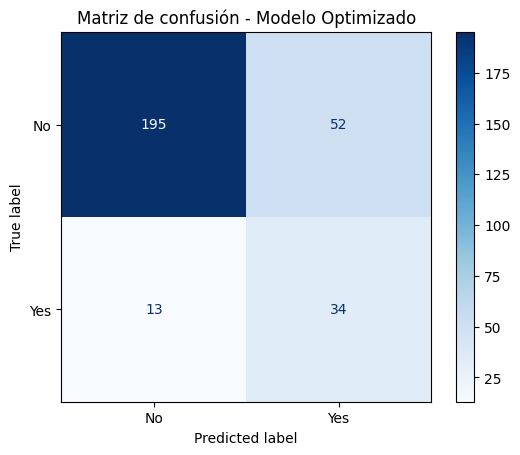

In [81]:
# Definimos el grid de hiperpar√°metros
param_grid = {
  'classifier__C': [3.75],
  'classifier__class_weight': ['balanced'],
  'classifier__penalty': ['l1'],
  'classifier__solver': ['liblinear']
}

# Configuramos el GridSearch con validaci√≥n cruzada y optimizaci√≥n de recall
grid_search = GridSearchCV(
    estimator=baseline_model,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Entrenamiento del GridSearch
grid_search.fit(X_train, y_train)

# Mostrar los mejores par√°metros encontrados
print(" Mejores hiperpar√°metros encontrados:")
print(grid_search.best_params_)

# Evaluaci√≥n del mejor modelo en el conjunto de test
y_pred_opt = grid_search.predict(X_test)

# Reporte de clasificaci√≥n del modelo optimizado
print("\n Classification Report - Modelo Optimizado (Logistic Regression):\n")
print(classification_report(y_test, y_pred_opt))

# Matriz de confusi√≥n
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_opt, cmap='Blues')
plt.title("Matriz de confusi√≥n - Modelo Optimizado")
plt.show()
# Guardar imagen
plt.savefig('src/img/matriz_confusion_logreg.png', dpi=300, bbox_inches='tight')
plt.close()

### Evaluaci√≥n final del modelo optimizado (Logistic Regression)

Tras ajustar el modelo con los mejores hiperpar√°metros, el rendimiento final sobre el conjunto de test ha sido el siguiente:

- **Recall para la clase Yes (rotaci√≥n)**: 0.72 ‚Üí El modelo es capaz de detectar correctamente al 72% de los empleados que realmente se van, cumpliendo con el objetivo principal del proyecto.
- **Precision para la clase Yes**: 0.40 ‚Üí Aunque existen falsos positivos, es un valor asumible si lo que se prioriza es minimizar la fuga real de talento.
- **F1-score para la clase Yes**: 0.51 ‚Üí Esta m√©trica armoniza precision y recall, y mejora significativamente respecto al modelo baseline.
- **Accuracy global**: 0.78 ‚Üí Buena tasa de aciertos generales, aunque recordemos que no es la m√©trica m√°s adecuada en casos con clases desbalanceadas.
- **Macro avg (recall)**: 0.76 ‚Üí Indica un equilibrio bastante correcto entre ambas clases.

En conjunto, estos resultados confirman que el modelo optimizado ha superado al baseline, sobre todo en el objetivo principal: detectar empleados con alta probabilidad de abandonar la empresa.


### Paso 9: Interpretabilidad del Modelo mediante Coeficientes

Vamos a entender c√≥mo cada variable influye en la predicci√≥n de la rotaci√≥n laboral. Para ello, vamos a analizar los **coeficientes del modelo**.

En este bloque de c√≥digo:

- Extraigo el modelo final entrenado desde el pipeline (`best_estimator_`).
- Accedo directamente al estimador de regresi√≥n log√≠stica (`classifier`) y al codificador de variables categ√≥ricas (`OneHotEncoder`) aplicado durante el preprocesamiento.
- Reconstruyo la lista completa de variables utilizadas, uniendo:
  - Las variables num√©ricas originales.
  - Las variables categ√≥ricas transformadas tras el OneHotEncoding.
- Creo un DataFrame con los nombres de las variables y sus coeficientes estimados por el modelo.
- A√±ado una columna que indica si cada variable **‚Üë aumenta** o **‚Üì disminuye** la probabilidad de que un empleado abandone la empresa.
- Finalmente, visualizo los coeficientes mediante un gr√°fico de barras horizontales.

Este paso es clave para convertir el modelo en una **herramienta explicativa y accionable** para el departamento de Recursos Humanos, ya que permite identificar qu√© factores est√°n m√°s asociados con el riesgo de abandono laboral.


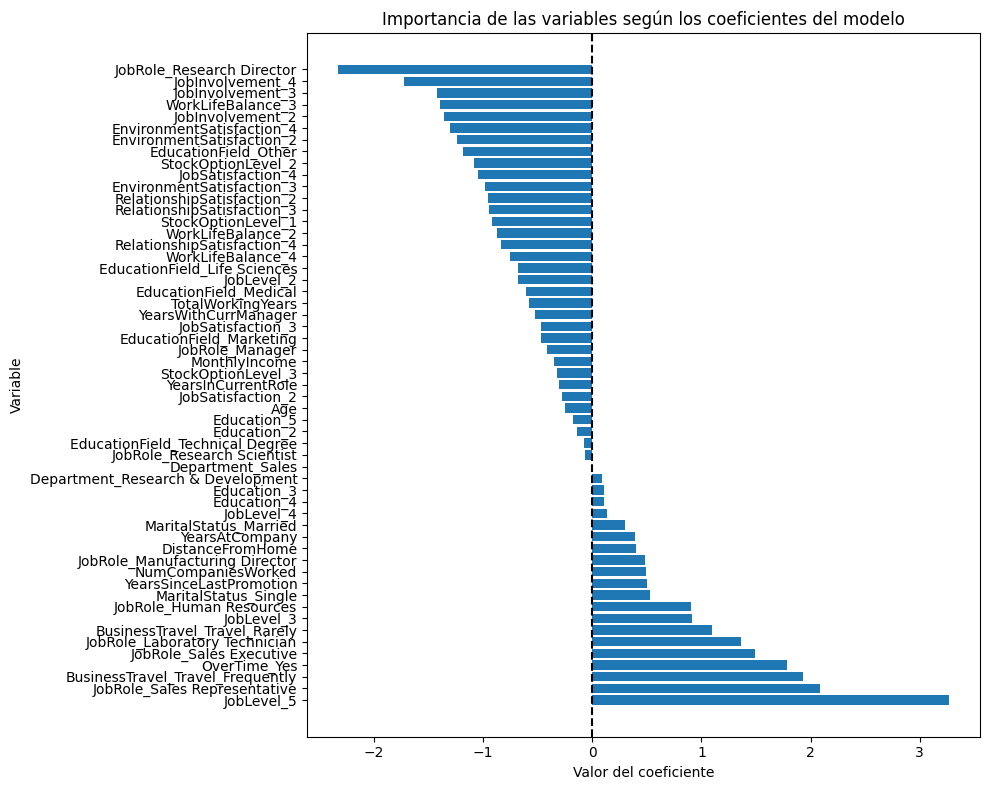

In [77]:
# Extraer el modelo entrenado del pipeline
best_model = grid_search.best_estimator_
log_reg = best_model.named_steps['classifier']
encoder = best_model.named_steps['preprocessor'].named_transformers_['cat']
encoded_features = encoder.get_feature_names_out(cat_features)

# Obtener nombres de todas las variables tras preprocesamiento
all_features = np.concatenate([num_features, encoded_features])

# Coeficientes y su impacto
coef = log_reg.coef_[0]
coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coeficiente': coef
})
coef_df['Impacto'] = coef_df['Coeficiente'].apply(lambda x: '‚Üë aumenta la probabilidad' if x > 0 else '‚Üì disminuye la probabilidad')
coef_df = coef_df.sort_values(by='Coeficiente', ascending=False)

# Visualizaci√≥n
plt.figure(figsize=(10, 8))
plt.barh(coef_df['Feature'], coef_df['Coeficiente'])
plt.axvline(0, color='black', linestyle='--')
plt.title('Importancia de las variables seg√∫n los coeficientes del modelo')
plt.xlabel('Valor del coeficiente')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()
# Guardar imagen
plt.savefig('./src/img/coeficientes_logreg.png', dpi=300, bbox_inches='tight')
plt.close()


In [74]:
coef_df

Variable  Coeficiente     Signo
36          cat__JobRole_Research Director    -2.332531  Negativo
27                   cat__JobInvolvement_4    -1.726625  Negativo
26                   cat__JobInvolvement_3    -1.423919  Negativo
53                  cat__WorkLifeBalance_3    -1.393046  Negativo
25                   cat__JobInvolvement_2    -1.361856  Negativo
24          cat__EnvironmentSatisfaction_4    -1.306571  Negativo
22          cat__EnvironmentSatisfaction_2    -1.237326  Negativo
20               cat__EducationField_Other    -1.182434  Negativo
50                 cat__StockOptionLevel_2    -1.080109  Negativo
42                  cat__JobSatisfaction_4    -1.047307  Negativo
23          cat__EnvironmentSatisfaction_3    -0.980949  Negativo
46         cat__RelationshipSatisfaction_2    -0.958098  Negativo
47         cat__RelationshipSatisfaction_3    -0.946526  Negativo
49                 cat__StockOptionLevel_1    -0.923400  Negativo
52                  cat__WorkLifeBalance_2    -0.873965  Negativo
48         cat__RelationshipSatisfaction_4    -0.840288  Negativo
54                  cat__WorkLifeBalance_4    -0.756042  Negativo
17       cat__EducationField_Life Sciences    -0.678073  Negativo
28                         cat__JobLevel_2    -0.676383  Negativo
19             cat__EducationField_Medical    -0.605831  Negativo
4                   num__TotalWorkingYears    -0.581377  Negativo
8                num__YearsWithCurrManager    -0.526574  Negativo
41                  cat__JobSatisfaction_3    -0.471523  Negativo
18           cat__EducationField_Marketing    -0.465520  Negativo
34                    cat__JobRole_Manager    -0.417240  Negativo
2                       num__MonthlyIncome    -0.347401  Negativo
51                 cat__StockOptionLevel_3    -0.325560  Negativo
6                  num__YearsInCurrentRole    -0.301609  Negativo
40                  cat__JobSatisfaction_2    -0.276087  Negativo
0                                 num__Age    -0.249451  Negativo
16                        cat__Education_5    -0.179502  Negativo
13                        cat__Education_2    -0.144025  Negativo
21    cat__EducationField_Technical Degree    -0.074341  Negativo
37         cat__JobRole_Research Scientist    -0.067575  Negativo
12                   cat__Department_Sales     0.000000  Negativo
11  cat__Department_Research & Development     0.090685  Positivo
14                        cat__Education_3     0.103835  Positivo
15                        cat__Education_4     0.111775  Positivo
30                         cat__JobLevel_4     0.134446  Positivo
43              cat__MaritalStatus_Married     0.296365  Positivo
5                      num__YearsAtCompany     0.392233  Positivo
1                    num__DistanceFromHome     0.400633  Positivo
35     cat__JobRole_Manufacturing Director     0.479207  Positivo
3                  num__NumCompaniesWorked     0.490273  Positivo
7             num__YearsSinceLastPromotion     0.505339  Positivo
44               cat__MaritalStatus_Single     0.529949  Positivo
32            cat__JobRole_Human Resources     0.904862  Positivo
29                         cat__JobLevel_3     0.918073  Positivo
10       cat__BusinessTravel_Travel_Rarely     1.094646  Positivo
33      cat__JobRole_Laboratory Technician     1.366759  Positivo
38            cat__JobRole_Sales Executive     1.486910  Positivo
45                       cat__OverTime_Yes     1.785303  Positivo
9    cat__BusinessTravel_Travel_Frequently     1.929677  Positivo
39       cat__JobRole_Sales Representative     2.084430  Positivo
31                         cat__JobLevel_5     3.272710  Positivo